#### 简要用贝叶斯概率模型计算
假设事件B为居民接种疫苗概率 事件A为居民感染的概率
- p(A|B)=p(B|A)*p(A)/p(B)=0.5*0.01/0.8=0.00625=0.625%
- p(A|~B)=0.5*0.01/0.2=0.025=2.5%
可发现接种疫苗对病毒有一定的免疫作用.但贝叶斯模型有较多缺点
- 基于特征条件独立假设进行分类，因此当数据集的特征存在关联时，分类效果不佳。
- 需要事先假设特征的先验分布，如果假设与真实情况不太符合，那么模型效果肯定也会受影响。而类别的先验分布也一般基于训练数据来计算，在数据没有代表性，不太能表征真实数据的情况下，也会产生较多误分类。
同时对拥有时间序列的数据处理效果不好，所以我们选取传染病模型对疫苗影响进行量化分析。

# 疾病传播模型简介,模型参数辨识
#### 1.SIR模型是常见的一种描述传染病传播的数学模型，其基本假设是将人群分为以下三类：

- 易感人群（Susceptible）：指未得病者，但缺乏免疫能力，与感病者接触后容易受到感染。

- 感染人群（Infective）：指染上传染病的人，他可以传播给易感人群。

- 移除人群（Removed）：被移出系统的人。因病愈（具有免疫力）或死亡的人。这部分人不再参与感染和被感染过程。

如下图所示，在SIR 模型中以上三类人群之间存在两个转换的关系：
!['SIR Explainer'](SIR_explainer.png)
 易感人群与感染人员接触时被传染，传染率为 \beta 。传染率反映了疾病传播的强度，传染率越大则易感人群和感染人员接触后被传染的可能性越大。

 感染人群以固定平均速率恢复或死亡。恢复率 \gamma ,取决于感染的平均持续时间 。

简化起见分别用三类人群的首字母S I R表示三类人群的数量,N表示人工总数。那么三类人群数量随时间的动态变化的规则可用以下常微分方程组表示：
![SIR](SIR.png)
#### 2.采用优化算法对传染率进行参数辨识
通过上面的介绍我们知道SIR模型实际上是采用动力学模型（三个常微分方程）对三类人群随时间变化的过程进行建模，采用传染率和恢复率来量化描述疾病传染和疾病被治愈等行为。很重要的一点是只有获得准确的动力学模型参数才有可能建立一个相对精确的模型。那么要采用SIR模型对新型肺炎传播进行建模其主要问题就是确定出以下参数

- 传染率 beta和恢复率 gamma

- 易感人群（Susceptible）初值，感染人群（Infective）初值，移除人群（Removed）初值

由于第一例病例是在12月8日被确诊，因此选择初始时间在12月8日。感染人群初值为1，易感人群初值为N-1，移除人群初值为0，其中N为武汉市总人口数。gamma为恢复率，因为新型冠状病毒肺炎的恢复期大约是14天，因此取 gamma = 1/14。因此下面我们主要是围绕如何辨识出准确的传染率beta
为了方便进行参数辨识，我们对上述SIR模型进行一个简化，我们认为在疾病传播的早期有S≈N(传播早期患病人数较少，所以可以近似认为所有人都是易感人群)，将这个条件带入到式（2）中可得
![Assumption1](assumption1.png)
决策变量：传染率 beta
目标函数：
![Assumption2](assumption2.png)



In [1]:
import torch
import numpy as np
arr=np.ones((3,3))
print("arr的数据类型为："+str(arr.dtype))
t=torch.tensor(arr)
print(t)

arr的数据类型为：float64
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


In [5]:
print(torch.cuda.is_available())

False


In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [2]:
# 核酸信息
dataTotal = pd.read_csv('F:/University/学期资料/大二下资料/泰迪杯/dataset/6acid.csv')
# 接种信息
dataVaccination = pd.read_csv('F:/University/学期资料/大二下资料/泰迪杯/dataset/7vac.csv')

In [3]:
# 接种疫苗的id集合
vaccinated_ids = dataVaccination.user_id.unique()

In [4]:
class preProcess:
    def __init__(self,data):
        self.Infection = data[data['jg'] == '阳性']
        self.Infection['cysj'] = pd.to_datetime(self.Infection['cysj']).dt.date
        self.Total = self.Infection.groupby('cysj')['jg'].size().cumsum()
        self.Total = self.Total.to_frame()
        self.Total.rename(columns = {"cysj":"时间","jg":"累计确诊"},inplace=True)
        print(self.Total)

    def report(self):
        plt.plot(self.Total.index, self.Total['时间'])
        plt.xlabel('Day')
        plt.ylabel('Number of people')
        plt.show()
    def getTotal(self):
        print (self.Total)

In [5]:
infectionData = preProcess(dataTotal)

            累计确诊
cysj            
2022-10-03     4
2022-10-04     7
2022-10-05    11
2022-10-06    19
2022-10-07    23
2022-10-08    28
2022-10-09    31
2022-10-10    35
2022-10-11    38
2022-10-12    47
2022-10-13    54
2022-10-14    57
2022-10-15    59
2022-10-16    62
2022-10-17    67
2022-10-18    69
2022-10-19    72
2022-10-20    78
2022-10-21    82
2022-10-22    93
2022-10-23    97
2022-10-24   105
2022-10-25   107
2022-10-26   113
2022-10-27   117
2022-10-28   122
2022-10-29   129
2022-10-30   138
2022-10-31   144
2022-11-01   157
2022-11-02   164
2022-11-03   197
2022-11-04   246
2022-11-05   301
2022-11-06   336
2022-11-07   356
2022-11-08   367
2022-11-09   386
2022-11-10   445
2022-11-11   516
2022-11-12   564
2022-11-13   591
2022-11-14   607
2022-11-15   617
2022-11-16   629
2022-11-17   641
2022-11-18   655
2022-11-19   680
2022-11-20   702
2022-11-21   752
2022-11-22   827
2022-11-23   888
2022-11-24   924
2022-11-25   936
2022-11-26   948
2022-11-27   967
2022-11-28   9

F:\Anaconda3 2022.10\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
infectionData.Total.reset_index(inplace=True)

In [7]:
class PreProcess_Vac:
    def __init__(self,data):
        self.Infection = data[data['jg'] == '阳性']
        self.Infection = self.Infection[self.Infection['user_id'].isin(vaccinated_ids.tolist())]
        self.Infection['cysj'] = pd.to_datetime(self.Infection['cysj']).dt.date
        self.Total = self.Infection.groupby('cysj')['jg'].size().cumsum()
        self.Total = self.Total.to_frame()
        self.Total.rename(columns = {"cysj":"时间","jg":"累计确诊"},inplace=True)
        print(self.Total)

    def report(self):
        plt.plot(self.Total.index, self.Total['时间'])
        plt.xlabel('Day')
        plt.ylabel('Number of people')
        plt.show()

    def getTotal(self):
        print (self.Total)

In [8]:
infectionData_Vac = PreProcess_Vac(dataTotal)


            累计确诊
cysj            
2022-11-12    16
2022-11-13    43
2022-11-14    59
2022-11-15    69
2022-11-16    81
2022-11-17    93
2022-11-18   107
2022-11-19   132
2022-11-20   154
2022-11-21   204
2022-11-22   279
2022-11-23   340
2022-11-24   376
2022-11-25   388
2022-11-26   400
2022-11-27   419
2022-11-28   439
2022-11-29   457
2022-11-30   475
2022-12-01   484


In [9]:
infectionData_Vac.Total.reset_index(inplace=True)

In [10]:
infectionData_Part = infectionData.Total.iloc[40:70]
infectionData_Part.reset_index(inplace=True)
infectionData_Part = infectionData_Part.drop(columns=['index'])
infectionData_Part

,cysj,累计确诊
0,2022-11-12,564
1,2022-11-13,591
2,2022-11-14,607
3,2022-11-15,617
4,2022-11-16,629
5,2022-11-17,641
6,2022-11-18,655
7,2022-11-19,680
8,2022-11-20,702
9,2022-11-21,752


In [11]:
class estimationInfectionProb:
    def __init__(self, estUsedTimeIndexBox, nContact, gamma):
        self.timeRange = np.array([i for i in range(estUsedTimeIndexBox[0],estUsedTimeIndexBox[1] + 1)])
        self.nContact, self.gamma = nContact, gamma
        self.dataStartTimeStep = estUsedTimeIndexBox[0]

    def setInitSolution(self, x0):
        self.x0 = 0.04

    def costFunction(self, infectionProb):
        res = np.array(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange) - \
                       infectionData.Total.loc[self.timeRange - self.dataStartTimeStep,'累计确诊'])
        return (res**2).sum() / self.timeRange.size

    def optimize(self):
        self.solution = minimize(self.costFunction, self.x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
        print('infection probaility: ', self.solution.x)
        return self.getSolution()

    def getSolution(self):
        return self.solution.x

    def getBasicReproductionNumber(self):
        self.basicReproductionNumber = self.nContact * self.solution.x[0] / (self.gamma)
        print("basic reproduction number:", self.basicReproductionNumber)
        return self.basicReproductionNumber
    def getBeta(self):
        self.beta = self.nContact * self.getSolution()
        print("beta:",self.beta)
        return self.beta

In [12]:
class estimationInfectionProb_Vac:
    def __init__(self, estUsedTimeIndexBox, nContact, gamma):
        self.timeRange = np.array([i for i in range(estUsedTimeIndexBox[0],estUsedTimeIndexBox[1] + 1)])
        self.nContact, self.gamma = nContact, gamma
        self.dataStartTimeStep = estUsedTimeIndexBox[0]

    def setInitSolution(self, x0):
        self.x0 = 0.04

    def costFunction(self, infectionProb):
        res = np.array(np.exp((infectionProb * self.nContact - self.gamma) * self.timeRange) - \
                       infectionData_Vac.Total.loc[self.timeRange - self.dataStartTimeStep,'累计确诊'])
        return (res**2).sum() / self.timeRange.size

    def optimize(self):
        self.solution = minimize(self.costFunction, self.x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
        print('infection probaility: ', self.solution.x)
        return self.getSolution()

    def getSolution(self):
        return self.solution.x

    def getBasicReproductionNumber(self):
        self.basicReproductionNumber = self.nContact * self.solution.x[0] / (self.gamma)
        print("basic reproduction number:", self.basicReproductionNumber)
        return self.basicReproductionNumber
    def getBeta(self):
        self.beta = self.nContact * self.getSolution()
        print("beta:",self.beta)
        return self.beta

In [13]:
# startTime 表示计算感染概率使用数据的开始日期
# estUsedTimeBox 表示计算用数据的开始日期和截止日期

startTime = datetime.datetime.strptime('2022-10-03', "%Y-%m-%d")
startTime_Vac = datetime.datetime.strptime('2022-11-12', "%Y-%m-%d")
estUsedTimeBox = [datetime.datetime.strptime('2022-10-03', "%Y-%m-%d"), datetime.datetime.strptime('2022-12-01', "%Y-%m-%d")]
estUsedTimeBox_Vac = [datetime.datetime.strptime('2022-11-12', "%Y-%m-%d"), datetime.datetime.strptime('2022-12-01', "%Y-%m-%d")]
estUsedTimeIndexBox = [(t - startTime).days for t in estUsedTimeBox]
estUsedTimeIndexBox_Compared = [(t - startTime).days for t in estUsedTimeBox_Vac]
estUsedTimeIndexBox_Vac = [(t - startTime_Vac).days for t in estUsedTimeBox_Vac]


In [14]:
# 划分6天为一个区间
indexBox = list()
for i in range(10):
    indexBoxTemp = [i*6,i*6+6]
    indexBox.append(indexBoxTemp)
indexBox
# 批量计算各个区间R0
nContact, gamma = int(5), 1/14
basicReproductionNumberArr_All = list()
betaArr_All = list()
for i in range(len(indexBox)):
    estInfectionProb_temp = estimationInfectionProb(indexBox[i], nContact, gamma)
    estInfectionProb_temp.setInitSolution(0.04)
    infectionProb_temp = estInfectionProb_temp.optimize()
    basicReproductionNumber_temp = estInfectionProb_temp.getBasicReproductionNumber()
    beta_temp = estInfectionProb_temp.getBeta()
    basicReproductionNumberArr_All.append(basicReproductionNumber_temp)
    betaArr_All.append(beta_temp)

Optimization terminated successfully.
         Current function value: 71.076333
         Iterations: 28
         Function evaluations: 56
infection probaility:  [0.13549424]
basic reproduction number: 9.48459678649904
beta: [0.6774712]
Optimization terminated successfully.
         Current function value: 8.444675
         Iterations: 25
         Function evaluations: 50
infection probaility:  [0.07359811]
basic reproduction number: 5.151867446899417
beta: [0.36799053]
Optimization terminated successfully.
         Current function value: 11.727794
         Iterations: 23
         Function evaluations: 46
infection probaility:  [0.05241314]
basic reproduction number: 3.668919754028321
beta: [0.2620657]
Optimization terminated successfully.
         Current function value: 23.843395
         Iterations: 19
         Function evaluations: 38
infection probaility:  [0.04202689]
basic reproduction number: 2.9418820190429686
beta: [0.21013443]
Optimization terminated successfully.
         

In [15]:
# 划分6天为一个区间
indexBox_Vac = list()
for i in range(3):
    indexBoxTemp = [i*6,i*6+6]
    indexBox_Vac.append(indexBoxTemp)
# 批量计算各个区间R0
nContact, gamma = int(5), 1/5
basicReproductionNumberArr_Vac = list()
betaArr_Vac = list()
for i in range(len(indexBox_Vac)):
    estInfectionProb_temp = estimationInfectionProb(indexBox_Vac[i], nContact, gamma)
    estInfectionProb_temp.setInitSolution(0.04)
    infectionProb_temp = estInfectionProb_temp.optimize()
    basicReproductionNumber_temp = estInfectionProb_temp.getBasicReproductionNumber()
    beta_temp = estInfectionProb_temp.getBeta()
    basicReproductionNumberArr_Vac.append(basicReproductionNumber_temp)
    betaArr_Vac.append(beta_temp)

Optimization terminated successfully.
         Current function value: 71.076333
         Iterations: 29
         Function evaluations: 58
infection probaility:  [0.16120853]
basic reproduction number: 4.030213165283208
beta: [0.80604263]
Optimization terminated successfully.
         Current function value: 8.444675
         Iterations: 27
         Function evaluations: 54
infection probaility:  [0.09931239]
basic reproduction number: 2.482809829711916
beta: [0.49656197]
Optimization terminated successfully.
         Current function value: 11.727794
         Iterations: 26
         Function evaluations: 52
infection probaility:  [0.07812743]
basic reproduction number: 1.9531856536865246
beta: [0.39063713]


可视化总人口和疫苗接种人口的$R_0$,直观展示疫苗效果
计算单位为6天

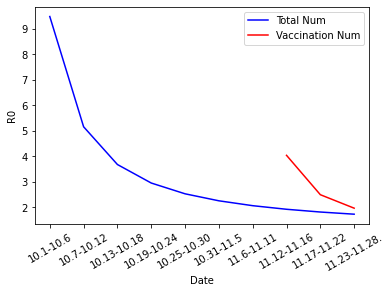

In [16]:
# 两个折线图的数据
x1 = range(1, 11) # 对应10月1日-10月10日
y1 = basicReproductionNumberArr_All

x2 = range(1, 11) # 对应10月1日-10月10日
basicReproductionNumberArr_Vac = [0] * 7 + basicReproductionNumberArr_Vac
y2 = basicReproductionNumberArr_Vac

# 只展示非零数据的索引
nonzero_idx1 = [i for i in range(len(y1)) if y1[i] != 0]
nonzero_idx2 = [i for i in range(len(y2)) if y2[i] != 0]

# 创建一个新的figure和axes对象
fig, ax = plt.subplots()

# 绘制两个折线图
ax.plot([x1[i] for i in nonzero_idx1], [y1[i] for i in nonzero_idx1], color='blue',label = 'Total Num')
ax.plot([x2[i] for i in nonzero_idx2], [y2[i] for i in nonzero_idx2], color='red',label = 'Vaccination Num')

# 设置x轴和y轴的标签
ax.set_xlabel('Date')
ax.set_ylabel('R0')

# 设置x轴刻度
ax.set_xticks(x1)
ax.set_xticklabels(['10.1-10.6', '10.7-10.12', '10.13-10.18', '10.19-10.24', '10.25-10.30', '10.31-11.5', '11.6-11.11', '11.12-11.16', '11.17-11.22', '11.23-11.28.'],rotation = 30)
plt.legend()
#保存图像
plt.savefig('img\\R0_Compare_Visualization')

# 显示图形
plt.show()


nContact 表示感染者接触的未感染者人数，其会因为政府管控措施，地区密集度等因素而改变,此处使用任务一的数据（阳性人员人均密接人数）为nContact
gamma 表示疾病的恢复率，新冠康复天数在5-21天不等，不同毒株的恢复率相差较大
![](Beta_calculation.png)

10.3-12.1 总人口

In [17]:
nContact, gamma = int(5), 1/14
estInfectionProb = estimationInfectionProb(estUsedTimeIndexBox, nContact, gamma)
estInfectionProb.setInitSolution(0.04)
infectionProb = estInfectionProb.optimize()
basicReproductionNumber = estInfectionProb.getBasicReproductionNumber()
beta_0 = estInfectionProb.getBeta()
gamma_0 = 0.0714

Optimization terminated successfully.
         Current function value: 50398.008488
         Iterations: 19
         Function evaluations: 38
infection probaility:  [0.03918607]
basic reproduction number: 2.7430245971679685
beta: [0.19593033]


病毒传播指数一般指的是病毒基本传染数（R0）,通过对数据清洗，数据预处理，数据分析，我们得到了在该时段的基本再生数。
![](R0.png)
感染概率(Infection probaility):  0.0392
基本再生数$R_0$(Basic reproduction number): 2.7430
传染率($\beta$):0.1959
治愈率($\gamma$):1/14 = 0.0714

#### 对比两种人群在最初20天的$R_0$

10.3-10.22 总人口（包含接种人口和未接种人口）

In [18]:
nContact, gamma = int(5), 1/14
estInfectionProb_Compared = estimationInfectionProb_Vac(estUsedTimeIndexBox_Vac, nContact, gamma)
estInfectionProb_Compared.setInitSolution(0.04)
infectionProb_Compared = estInfectionProb_Compared.optimize()
basicReproductionNumber_Compared = estInfectionProb_Compared.getBasicReproductionNumber()
beta_1 = estInfectionProb_Compared.getBeta()
gamma_1 = 0.0714

Optimization terminated successfully.
         Current function value: 33253.720729
         Iterations: 26
         Function evaluations: 52
infection probaility:  [0.08343816]
basic reproduction number: 5.840671463012701
beta: [0.41719082]


11.12-12.1 接种疫苗

In [19]:
nContact, gamma = int(5), 1/6
estInfectionProb_Vac = estimationInfectionProb_Vac(estUsedTimeIndexBox_Vac, nContact, gamma)
estInfectionProb_Vac.setInitSolution(0.04)
infectionProb_Vac = estInfectionProb_Vac.optimize()
basicReproductionNumber_Vac = estInfectionProb_Vac.getBasicReproductionNumber()
beta_2 = estInfectionProb_Vac.getBeta()
gamma_2 = 0.1667

Optimization terminated successfully.
         Current function value: 33253.720729
         Iterations: 27
         Function evaluations: 54
infection probaility:  [0.10248578]
basic reproduction number: 3.0745733642578155
beta: [0.51242889]


我们发现，与总人口对比，接种疫苗人群中$R_0$在传播开始的20天有显著下降，由5.84下降值3.07，约为原有的52%

#### 3.参数辨识结果
我们得到的辨识结果为
- 感染概率(Infection probaility):  0.0392
- 传染率($\beta$):0.1959
- 治愈率($\gamma$):1/14 = 0.0714
同时可以采用如下公式估算出 新型肺炎病毒基本传染数
- 基本再生数$R_0$(Basic reproduction number): 2.7430

同时由问题一可知道，密接人次:90203，感染人次:1032，密接排查时长:3天
- $Contact_a_v_g= 90203/(1032*3)=29.14人/日$
由于我们密接者的定义较于疾病传播学的日均接触人数nContact有差异，所以取原有的1/6
- $nContact = Contact_a_v_g / 6 = 4.86 ≈ 5$

参考文献
1.SIR模型简介 基于SIR模型对新冠肺炎疫情基本再生数的研究_薛依琳
2.采用优化算法对传染率进行参数辨识 参考文献：Andrea Palladino Modelling the spread of Covid19 in Italy using a revised version of the SIR model
3.参数辨识结果 参考文献：https://zhuanlan.zhihu.com/p/104645873

#### 4.建立传染病模型
利用参数便是结果，建立SIR，SEIR，SEIDR理想模型，并最后引入疫苗的影响，模拟理想状态下疫苗接种对疾病传播的影响

In [20]:
import scipy.integrate as spi
import numpy as np
import matplotlib.pyplot as plt

一个病人能够传染的人数为β，移出者在病人中所占的比例为γ
![SIR](SIR.png)

In [21]:
# N为人群总数
N = 10000
# β为传染率系数
beta = beta_0
# gamma为恢复率系数
gamma = gamma_0
# I_0为感染者的初始人数
I_0 = 1
# R_0为治愈者的初始人数
R_0 = 0
# S_0为易感者的初始人数
S_0 = N - I_0 - R_0
# T为传播时间
T = 150

# INI为初始状态下的数组
INI = (S_0,I_0,R_0)


In [22]:
def funcSIR(inivalue,_):
    Y = np.zeros(3)
    X = inivalue
    # 易感个体变化
    Y[0] = - (beta * X[0] * X[1]) / N
    # 感染个体变化
    Y[1] = (beta * X[0] * X[1]) / N - gamma * X[1]
    # 治愈个体变化
    Y[2] = gamma * X[1]
    return Y

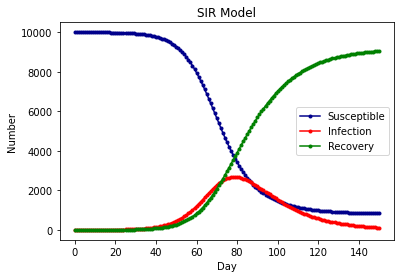

In [23]:
T_range = np.arange(0,T + 1)

RES = spi.odeint(funcSIR,INI,T_range)

plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptible',marker = '.')
plt.plot(RES[:,1],color = 'red',label = 'Infection',marker = '.')
plt.plot(RES[:,2],color = 'green',label = 'Recovery',marker = '.')
plt.title('SIR Model')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.savefig('img\\SIR_model.jpg')
plt.show()


SEIR 无疫苗影响 潜伏期模型
参考资料：修正SEIR传染病动力学模...ID-19)疫情预测和评估_曹盛力

![](SEIR_latent.png)

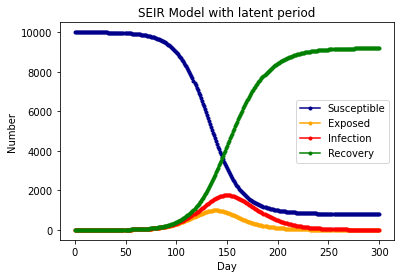

In [24]:
# N为人群总数
N = 10000
# β为传染率系数
beta = beta_0
# gamma为恢复率系数
gamma = gamma_0
# Te为疾病潜伏期
Te = 7
# I_0为感染者的初始人数
I_0 = 1
# E_0为潜伏者的初始人数
E_0 = 0
# R_0为治愈者的初始人数
R_0 = 0
# S_0为易感者的初始人数
S_0 = N - I_0 - E_0 - R_0
# T为传播时间
T = 300

# INI为初始状态下的数组
INI = (S_0,E_0,I_0,R_0)


def funcSEIR(inivalue,_):
    Y = np.zeros(4)
    X = inivalue
    # 易感个体变化
    Y[0] = - (beta * X[0] * X[2]) / N
    # 潜伏个体变化（每日有一部分转为感染者）
    Y[1] = (beta * X[0] * X[2]) / N - X[1] / Te
    # 感染个体变化
    Y[2] = X[1] / Te - gamma * X[2]
    # 治愈个体变化
    Y[3] = gamma * X[2]
    return Y

T_range = np.arange(0,T + 1)

RES = spi.odeint(funcSEIR,INI,T_range)


plt.plot(RES[:,0],color = 'darkblue',label = 'Susceptible',marker = '.')
plt.plot(RES[:,1],color = 'orange',label = 'Exposed',marker = '.')
plt.plot(RES[:,2],color = 'red',label = 'Infection',marker = '.')
plt.plot(RES[:,3],color = 'green',label = 'Recovery',marker = '.')

plt.title('SEIR Model with latent period')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Number')
plt.savefig('img\\SEIR_model.jpg')
plt.show()


#### SEIDR模型 无疫苗影响 考虑死亡率
- 在这里，假定患病者(Infectious)在患病期间有概率康复或死亡，设定死亡率为\delta；则在患病期间，患者可以转化为康复者(Recovered)和死亡者(Dead)，则延伸为SEIDR模型，其微分公式如下：
!['SEIDR'](SEIDR.png)
参考资料：https://github.com/moyuweiqing/SEIR-Model-extension

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
def dySEIDR(y, t, alpha, beta, gamma, delta, lamda):
    s, e, i, d, r = y
    n = s + e + i + d + r

    # print(s, e, i, d, r)
    ds_dt = - lamda * beta * s * (i + e) / n
    de_dt = lamda * beta * s * (i + e) / n - alpha * e
    di_dt = alpha * e - gamma * i - delta * i
    dd_dt = delta * i
    dr_dt = gamma * i

    return np.array([ds_dt, de_dt, di_dt, dd_dt, dr_dt])

def draw_SEIDR(ySEIR):
    plt.figure(figsize=(16, 9))
    plt.plot(t, ySEIR[:, 0], '--', label='s(t)--SEIR')
    plt.plot(t, ySEIR[:, 1], '-.', label='e(t)--SEIR')
    plt.plot(t, ySEIR[:, 2], '-', label='i(t)--SEIR')
    plt.plot(t, ySEIR[:, 3], '.', label='d(t)--SEIR')
    plt.plot(t, ySEIR[:, 4], '--', label='r(t)--SEIR')
    plt.legend()
    # plt.show()
    plt.savefig('img\\SEIDR_model with No Vaccination.jpg')

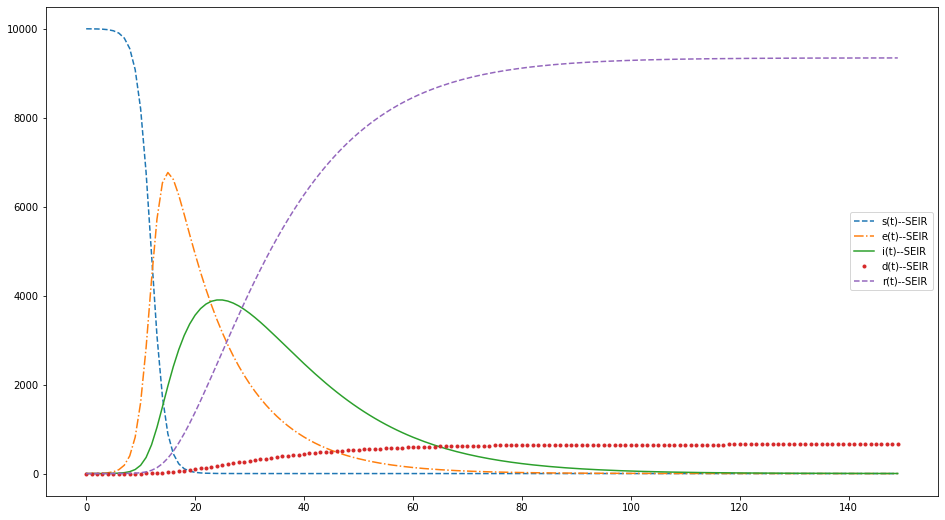

In [26]:
number = 10000      # 模型总人数

s = 9999            # Susceptible 易感人群数量
e = 0               # Exposed 暴露者/潜伏者
i = 1               # Infected 感染者
d = 0               # Dead 死亡者
r = 0               # Recovered 康复者

alpha = 0.09                        # Probability of latent people becoming infected people 潜伏期的人变成感染者的概率
beta  = round(float(beta_0),4)      # For susceptible persons, probability of becoming latent after contact with infected persons 对于易感者，与感染者接触后成为潜伏者的可能性
gamma = round(float(gamma_0),4)     # Cure rate of infected persons 感染者的治愈率
delta = 0.005                       # Death rate of infected persons 感染者的死亡率
lamda = 4                           # Number of susceptible persons exposed by infected persons per unit time 单位时间内受感染者接触的易受感染人数

tEnd = 150          # 150天
t = np.arange(0, tEnd, 1)

Y0 = (s, e, i, d, r)
ySEIDR = odeint(dySEIDR, Y0, t, args=(alpha, beta, gamma, delta, lamda))
draw_SEIDR(ySEIDR)

# 引入疫苗(vaccine)的接种影响因素，接种疫苗可以直接反映在SEIDR中的感染率、死亡率、康复率，影响传染病的致死率  数值情况。具体的影响可以基本分为以下四种情况作进一步讨论：

- 一剂疫苗，在传染病发生时期即存在疫苗，在传染病爆发的同时开始接种疫苗。
- 一剂疫苗，传染病发生时并无疫苗，疫苗相对于传染病传播具有延迟性，在传染病开始爆发T日后开始接种疫苗。
- 二剂疫苗，在传染病发生时期即存在疫苗，在传染病爆发的同时开始接种第一剂疫苗；在两针疫苗的间隔期后开始接种第二剂疫苗。
- 二剂疫苗，传染病发生时并无疫苗，疫苗相对于传染病传播具有延迟性，在传染病开始爆发T日后开始接种第一剂疫苗；在两针疫苗的间隔期后开始接种第二剂疫苗。
- 引入该变量后，模型的基本微分公式如下：

![SEIDR_VAC](SEIDR_VAC.png)

*其中，i = (0,1,2)是对应的是未接种疫苗、接种一剂疫苗和接种两剂疫苗的情况，S_{i}、E_{i}、I_{i}分别是不同疫苗接种情况的易感人群、潜伏者和感染者，\beta _{i}、\gamma_{i}、\delta_{i}分别对应不同疫苗接种情况下各个人群的患病率、康复率、死亡率。\nu _{j}, j\epsilon \left ( 1,2 \right )表示一剂疫苗的日接种率和二剂疫苗的日接种率。*

参考资料：https://github.com/moyuweiqing/SEIR-Model-extension

In [27]:
def dySEIDR_V(y, t, alpha, beta0, beta1, gamma0, gamma1, delta0, delta1, lamda, v):
    s0, s1, e0, e1, i0, i1, d0, d1, r = y
    n = s0 + s1 + e0 + e1 + i0 + i1 + d0 + d1 + r

    ds0_dt = - lamda * beta0 * s0 * ( i0 + i1 + e0 + e1 ) / n - v * s0
    ds1_dt = - lamda * beta1 * s1 * ( i0 + i1 + e0 + e1 ) / n + v * s0
    de0_dt = lamda * beta0 * s0 * ( i0 + i1 + e0 + e1 ) / n - alpha * e0
    de1_dt = lamda * beta1 * s1 * ( i0 + i1 + e0 + e1 ) / n - alpha * e1
    di0_dt = alpha * e0 - gamma0 * i0 - delta0 * i0
    di1_dt = alpha * e1 - gamma1 * i1 - delta1 * i1
    dd0_dt = delta0 * i0
    dd1_dt = delta1 * i1
    dr_dt = gamma0 * i0 + gamma1 * i1

    return np.array([ds0_dt, ds1_dt, de0_dt, de1_dt, di0_dt, di1_dt, dd0_dt, dd1_dt, dr_dt])

def draw_SEIDR(ySEIR):
    plt.figure(figsize=(16, 9))
    plt.plot(t, ySEIR[:, 0] + ySEIR[:, 1], '--', label='s(t)--SEIR')
    plt.plot(t, ySEIR[:, 2] + ySEIR[:, 3], '-.', label='e(t)--SEIR')
    plt.plot(t, ySEIR[:, 4] + ySEIR[:, 5], '-', label='i(t)--SEIR')
    plt.plot(t, ySEIR[:, 6] + ySEIR[:, 7], '.', label='d(t)--SEIR')
    plt.plot(t, ySEIR[:, 8], '--', label='r(t)--SEIR')
    plt.legend()
    # plt.show()
    plt.savefig('img\\SEIDR_model with VACCINATION.jpg')

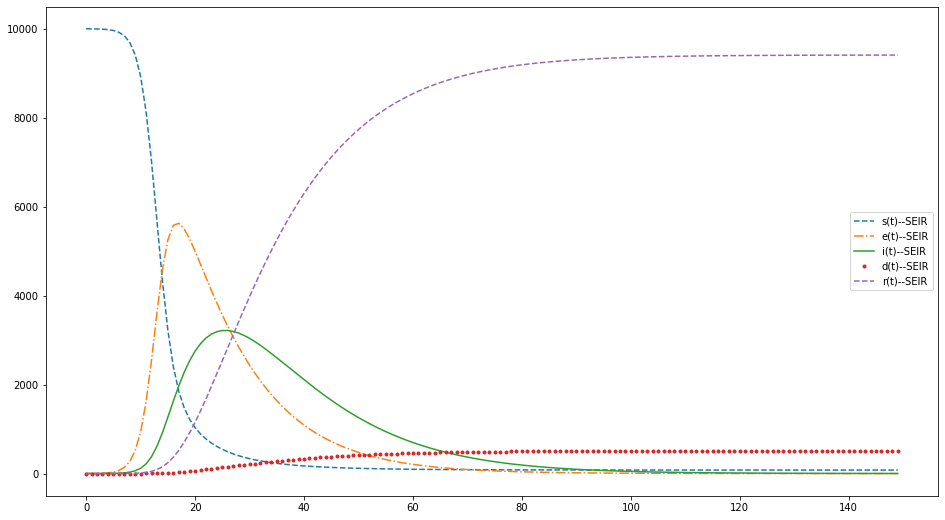

In [28]:
number = 10000      # 模型总人数

s = 9990            # Susceptible 易感人群数量
e = 0               # Exposed 暴露者/潜伏者
i = 10              # Infected 感染者
d = 0               # Dead 死亡者
r = 0               # Recovered 康复者

alpha = 0.09                        # Probability of latent people becoming infected people 潜伏期的人变成感染者的概率
beta  = round(float(beta_0),4)      # For susceptible persons, probability of becoming latent after contact with infected persons 对于易感者，与感染者接触后成为潜伏者的可能性
gamma = round(float(gamma_0),4)     # Cure rate of infected persons 感染者的治愈率
delta = 0.005                       # Death rate of infected persons 感染者的死亡率
lamda = 4                           # Number of susceptible persons exposed by infected persons per unit time 单位时间内受感染者接触的易受感染人数

tEnd = 150          # 150天
t = np.arange(0, tEnd, 1)

v = 0.02                # Vaccination coverage rates 疫苗接种率
beta0 = beta            # The probability of becoming latent in unvaccinated population 未打疫苗人群的患病概率
beta1 = beta0 * 0.2     # The probability of becoming latent in vaccinated population 已打疫苗人群的感染率
gamma0 = gamma          # Cure rates of unvaccinated infected persons 未接种疫苗的感染者的治愈率
gamma1 = gamma0 * 5     # The cure rate of vaccinated infected people 接种了疫苗的感染者的治愈率
delta0 = delta          # Death rate of unvaccinated infected persons 未接种疫苗的感染者的死亡率
delta1 = delta0 * 0.2   # Death rate of vaccinated infected persons 接种了疫苗的感染者的死亡率
s0 = 9999
s1 = 0
e0 = 0
e1 = 0
i0 = 1
i1 = 0
d0 = 0
d1 = 0

Y0 = (s0, s1, e0, e1, i0, i1, d0, d1, r)
ySEIDR_Vac = odeint(dySEIDR_V, Y0, t, args=(alpha, beta0, beta1, gamma0, gamma1, delta0, delta1, lamda, v))
draw_SEIDR(ySEIDR_Vac)

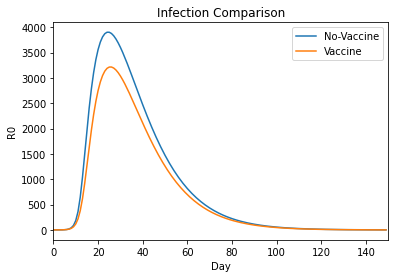

In [29]:
# Infection Comparison
plt.plot(ySEIDR[:,2], label='No-Vaccine')
plt.plot(ySEIDR_Vac[:, 4] + ySEIDR_Vac[:, 5], label='Vaccine')

# add a title and labels to the axes
plt.title('Infection Comparison')
plt.xlabel('Day')
plt.ylabel('R0')

plt.xlim(0,tEnd)

# add a legend to the plot
plt.legend()

plt.savefig('img\\Infection_Comparison.jpg')
# display the plot
plt.show()

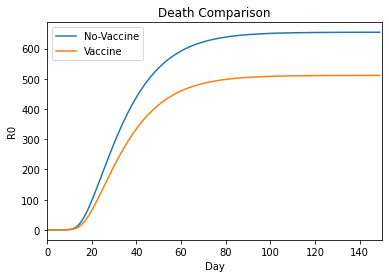

In [30]:
# Comparison
plt.plot(ySEIDR[:,3], label='No-Vaccine')
plt.plot(ySEIDR_Vac[:, 6] + ySEIDR_Vac[:, 7], label='Vaccine')

# add a title and labels to the axes
plt.title('Death Comparison')
plt.xlabel('Day')
plt.ylabel('R0')

plt.xlim(0,tEnd)

# add a legend to the plot
plt.legend()

plt.savefig('img\\Death_Comparison.jpg')
# display the plot
plt.show()

![](R0.png)

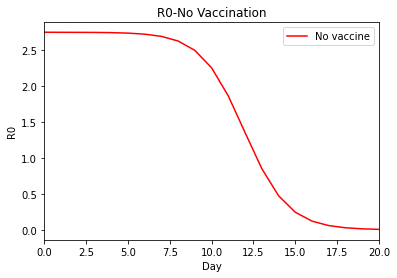

In [31]:
# 未接种疫苗
# R0(t) = beta*S(t)/(N*gamma)
R0_t_raw = beta * ySEIDR[:,0] / (N*gamma)
plt.plot(R0_t_raw, label='No vaccine',color = 'red')

# add a title and labels to the axes
plt.title('R0-No Vaccination')
plt.xlabel('Day')
plt.ylabel('R0')

plt.xlim(0,20)
# add a legend to the plot
plt.legend()
# display the plot
plt.show()

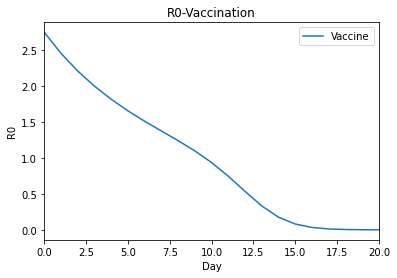

In [32]:
# 接种疫苗
# R0(t) = beta*S(t)/(N*gamma)
beta_avg = ySEIDR_Vac[:,0]*beta0/N + ySEIDR_Vac[:,1]*beta1/N
gamma_avg = ySEIDR_Vac[:,0]*gamma0/N + ySEIDR_Vac[:,1]*gamma1/N

R0_t = beta_avg * ySEIDR_Vac[:,0] / (N*gamma_avg)
plt.plot(R0_t, label='Vaccine')

# add a title and labels to the axes
plt.title('R0-Vaccination')
plt.xlabel('Day')
plt.ylabel('R0')

plt.xlim(0,20)
# add a legend to the plot
plt.legend()
# display the plot
plt.show()

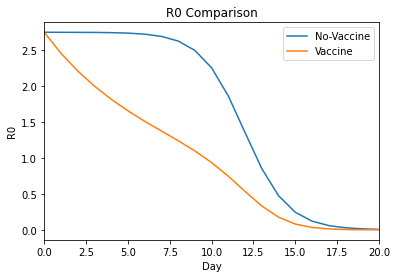

In [33]:
# Comparison
plt.plot(R0_t_raw, label='No-Vaccine')
plt.plot(R0_t, label='Vaccine')

# add a title and labels to the axes
plt.title('R0 Comparison')
plt.xlabel('Day')
plt.ylabel('R0')

plt.xlim(0,20)

# add a legend to the plot
plt.legend()

plt.savefig('img\\R0_Comparison.jpg')
# display the plot
plt.show()